# Benchmark against Biolord

## Imports

In [1]:

import scanpy as sc
import numpy as np
import torch
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
import glob
import matplotlib.pyplot as plt


In [ ]:
import DeepDive
import biolord

In [2]:
def r2_score(y_true, y_pred):

    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return r2


In [4]:
def evaluate(test_adata, 
             model_, 
             discrete_covriate_keys, 
             continuous_covriate_keys, 
             ct_name = '', 
             dataset_name = '', 
             marker_dir = '', 
             benchmark_directory = '../Benchmark_models', model = 'DeepDive'):
    
    # Load markers
    markers = pd.read_csv(f"{marker_dir}/{dataset_name}_markers.tsv", sep = '\t', index_col = 0)['0'].tolist()
    idx = [x in markers for x in test_adata.var_names]
    
    # Predict
    rec = model.predict(test_adata, covars_to_add = discrete_covriate_keys + continuous_covriate_keys,
                                batch_size = 256, num_workers = 10, add_unknown = True)

    ct = test_adata.obs[ct_name].unique()

    r2 = []
    for i in ct:
        true_sub_sub = test_adata[test_adata.obs[ct_name] == i].X.todense().mean(axis = 0)
        pred_sub_sub = np.array(rec[test_adata.obs[ct_name] == i].X).mean(axis = 0)
        r2.append(r2_score(np.array(true_sub_sub).flatten(), np.array(pred_sub_sub)))
    result_out = f'{benchmark_directory}/{model}/{dataset_name}_r2score.txt'
    np.savetxt(result_out, np.array(r2))
    



## Parameters

In [ ]:
#DeepDive params
n_decoders = 1  
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 512, 
}

In [ ]:
#Biolord params
module_params_bl = {
        "decoder_width": 512,
        "decoder_depth": 6,
        "attribute_nn_width": 256,
        "attribute_nn_depth": 2,
        "unknown_attribute_noise_param": 1e0,
        "seed": 42,
        "n_latent_attribute_ordered": 16,
        "n_latent_attribute_categorical": 16,
        "gene_likelihood": "poisson",
        "reconstruction_penalty": 1e1,
        "unknown_attribute_penalty": 1e0,
        "attribute_dropout_rate": 0.1
    } 
plan_kwargs_bl = {
        "n_epochs_warmup": 0,
        "decoder_lr": 1e-4,
        "decoder_wd": 1e-4,
        "attribute_nn_lr": 1e-2,
        "attribute_nn_wd": 4e-8,
        "step_size_lr": 45,
        "cosine_scheduler": True,
        "scheduler_final_lr": 1e-5,
    }

## NeuroIPS

### with cell types

In [ ]:
adata = sc.read_h5ad("Processed_benchmark_datasets/NeuroIPS.h5ad")

In [ ]:
discrete_covriate_keys = ['cell_type', 'batch', 'Site', 'DonorID',  'DonorBloodType',
       'DonorRace', 'Ethnicity', 'DonorGender', 'DonorSmoker']
continuous_covriate_keys = ['DonorAge', 'DonorBMI']
adata.obs.DonorID = adata.obs.DonorID.map(str)

In [ ]:
train_adata = adata[adata.obs.split == 'train']
validation_adata = adata[adata.obs.split == 'test']
test_adata = adata[adata.obs.split == 'ood']


In [ ]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [ ]:
model.train_model(train_adata, validation_adata, 
                  **train_params)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'NeuroIPS')

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=512,
    accelerator = 'gpu',
    plan_kwargs=plan_kwargs_bl,
    early_stopping=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'NeuroIPS', model = 'Biolord')

### Without cell types

In [ ]:
discrete_covriate_keys = ['batch', 'Site', 'DonorID',  'DonorBloodType',
       'DonorRace', 'Ethnicity', 'DonorGender', 'DonorSmoker']

In [ ]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [ ]:
model.train_model(train_adata, validation_adata, 
                  **train_params)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'NeuroIPS', benchmark_directory = '../Benchmark_models_no_ct')

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=512,
    accelerator = 'gpu',
    plan_kwargs=plan_kwargs_bl,
    early_stopping=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'NeuroIPS', 
         model = 'Biolord', benchmark_directory = '../Benchmark_models_no_ct')

### sciATAC3

In [ ]:
adata = sc.read_h5ad("../../Processed_benchmark_datasets/sciATAC3.h5ad")

In [ ]:
discrete_covriate_keys = ['donor_id', 'sex', 'batch', 'tissue', 'cell_type'
                         ]
continuous_covriate_keys = ['day_of_pregnancy']

In [ ]:
train_adata = adata[adata.obs.split == 'train']
validation_adata = adata[adata.obs.split == 'test']
test_adata = adata[adata.obs.split == 'ood']


### with cell types

In [ ]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [ ]:
model.train_model(train_adata, validation_adata, 
                  **train_params)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'sciATAC3')

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=512,
    accelerator = 'gpu',
    plan_kwargs=plan_kwargs_bl,
    early_stopping=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'sciATAC3', model = 'Biolord')

### Without cell types

In [ ]:
discrete_covriate_keys = ['donor_id', 'sex', 'batch', 'tissue', 
                         ]
continuous_covriate_keys = ['day_of_pregnancy']

In [ ]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [ ]:
model.train_model(train_adata, validation_adata, 
                  **train_params)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'sciATAC3', benchmark_directory = '../Benchmark_models_no_ct')

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=512,
    accelerator = 'gpu',
    plan_kwargs=plan_kwargs_bl,
    early_stopping=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'sciATAC3', 
         model = 'Biolord', benchmark_directory = '../Benchmark_models_no_ct')

### Gestation_cerebral_cortex

In [ ]:
adata = sc.read_h5ad("../../Processed_benchmark_datasets/Gestation_cerebral_cortex.h5ad")

In [ ]:
discrete_covriate_keys = ['Sample.ID', 'Tissue.ID', 'Sample.Type', 'Batch', 'Iterative.LSI.Clusters'
                         ]
continuous_covriate_keys = ['Age_int']

In [ ]:
adata.obs.columns = adata.obs.columns.map(lambda x:x.replace('.', ''))

In [ ]:
discrete_covriate_keys = [x.replace('.', '') for x in discrete_covriate_keys]

In [ ]:
adata.obs[discrete_covriate_keys] = adata.obs[discrete_covriate_keys].astype(str)

In [ ]:
train_adata = adata[adata.obs.split == 'train']
validation_adata = adata[adata.obs.split == 'test']
test_adata = adata[adata.obs.split == 'ood']

### with cell types

In [ ]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [ ]:
model.train_model(train_adata, validation_adata, 
                  **train_params)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'IterativeLSIClusters', dataset_name = 'Gestation_cerebral_cortex')

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=512,
    accelerator = 'gpu',
    plan_kwargs=plan_kwargs_bl,
    early_stopping=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'IterativeLSIClusters', dataset_name = 'Gestation_cerebral_cortex', model = 'Biolord')

### Without cell types

In [ ]:
discrete_covriate_keys = ['SampleID', 'TissueID', 'SampleType', 'Batch', 
                         ]

In [ ]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [ ]:
model.train_model(train_adata, validation_adata, 
                  **train_params)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'IterativeLSIClusters', dataset_name = 'Gestation_cerebral_cortex', benchmark_directory = '../Benchmark_models_no_ct')

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=512,
    accelerator = 'gpu',
    plan_kwargs=plan_kwargs_bl,
    early_stopping=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'IterativeLSIClusters', dataset_name = 'Gestation_cerebral_cortex', 
         model = 'Biolord', benchmark_directory = '../Benchmark_models_no_ct')

### Kidney

In [ ]:
adata = sc.read_h5ad("../../Processed_benchmark_datasets/Kidney.h5ad")

In [ ]:
discrete_covriate_keys = ['sample', 'celltype', 'gender', 'race']
continuous_covriate_keys = ['egfr', 'age']

In [ ]:
train_adata = adata[adata.obs.split == 'train']
validation_adata = adata[adata.obs.split == 'test']
test_adata = adata[adata.obs.split == 'ood']


### with cell types

In [ ]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [ ]:
model.train_model(train_adata, validation_adata, 
                  **train_params)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'celltype', dataset_name = 'Kidney')

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=512,
    accelerator = 'gpu',
    plan_kwargs=plan_kwargs_bl,
    early_stopping=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'celltype', dataset_name = 'Kidney', model = 'Biolord')

### Without cell types

In [ ]:
discrete_covriate_keys = ['sample', 'gender', 'race']


In [ ]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [ ]:
model.train_model(train_adata, validation_adata, 
                  **train_params)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'celltype', dataset_name = 'Kidney', benchmark_directory = '../Benchmark_models_no_ct')

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=512,
    accelerator = 'gpu',
    plan_kwargs=plan_kwargs_bl,
    early_stopping=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'celltype', dataset_name = 'Kidney', 
         model = 'Biolord', benchmark_directory = '../Benchmark_models_no_ct')

## Pancreas

In [ ]:
adata = sc.read_h5ad("../../Processed_benchmark_datasets/Pancreas_ATAC.h5ad")

In [ ]:
discrete_covriate_keys = ['donor', 'cell_type', 
                          'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', ' 10x multiome assay']
continuous_covriate_keys = ['Islet index', 'Age', 'BMI', 'HbA1c', 'Purity']

In [ ]:
train_adata = adata[adata.obs.split == 'train']
validation_adata = adata[adata.obs.split == 'test']
test_adata = adata[adata.obs.split == 'ood']


### with cell types

In [ ]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [ ]:
model.train_model(train_adata, validation_adata, 
                  **train_params)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'Pancreas_ATAC')

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=512,
    accelerator = 'gpu',
    plan_kwargs=plan_kwargs_bl,
    early_stopping=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'Pancreas_ATAC', model = 'Biolord')

### Without cell types

In [ ]:
discrete_covriate_keys = ['donor', 'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', ' 10x multiome assay']

In [ ]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [ ]:
model.train_model(train_adata, validation_adata, 
                  **train_params)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'Pancreas_ATAC', benchmark_directory = '../Benchmark_models_no_ct')

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model.train(
    max_epochs=100,
    batch_size=512,
    accelerator = 'gpu',
    plan_kwargs=plan_kwargs_bl,
    early_stopping=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

In [ ]:
evaluate(test_adata, model, discrete_covriate_keys, continuous_covriate_keys, 
         ct_name = 'cell_type', dataset_name = 'Pancreas_ATAC', 
         model = 'Biolord', benchmark_directory = '../Benchmark_models_no_ct')

### Plotting

In [121]:
data = {
    'Dataset_identifier': ['NeuroIPS', 'sciATAC3', 'Gestation_cerebral_cortex', 'Kidney', 'Pancreas_ATAC'],
    'Cells': [69249, 720613, 31304, 27034, 218973],
    'Features': [116490, 1050819, 657930, 195043, 557833],
    'Filtered_features': [16134, 9746, 52685, 34948, 33248],
    'Discrete_covariates': [
        ['cell_type', 'batch', 'Site', 'DonorID', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'DonorSmoker'],
        ['donor_id', 'sex', 'batch', 'tissue', 'cell_type'],
        ['Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'Iterative.LSI.Clusters'],
        ['sample', 'celltype', 'age', 'gender', 'race'],
        ['donor', 'cell_type', 'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', '10x multiome assay']
    ],
    'Continuous_covariates': [
        ['DonorAge', 'DonorBMI'],
        ['day_of_pregnancy'],
        ['Age_int'],
        ['egfr'],
        ['Islet index', 'Age', 'BMI', 'HbA1c', 'Purity']
    ],
    'Donors': [10, 20, 13, 5, 34]
}

df_methods = pd.DataFrame(data)

In [122]:
root = '../data/'

In [123]:
files = glob.glob('Benchmark_models*/*/*_*.txt', root_dir=root)

In [124]:
aggr = []
for f in files:
    run_type = f.split('/')[0]
    model = f.split('/')[1]
    dataset = '_'.join(f.split('/')[-1].split('_')[:-1])
    metric = f.split('/')[-1].split('_')[-1].split('.txt')[0]
    
    val = pd.read_csv(root+f, header = None).values#.item()

    for v in val:
        aggr.append([run_type, model, dataset, metric, v.item()])

In [125]:
df = pd.DataFrame(aggr,columns = ['run_type', 'model', 'dataset', 'metric', 'score'])

In [126]:
df['n_cells'] = df.dataset.map(df_methods.Cells.to_dict())

In [127]:
def mapper(string):
    name = '\n'.join(string.split('_'))
    name += "\n"
    name += str(df_methods.set_index('Dataset_identifier').Cells.to_dict()[string])
    name += ' cells'
    return name
    
df.dataset = [mapper(x) for x in df.dataset]

In [128]:
hue_order = ['biolord',
             'deepdive'] 


In [129]:
metrics = ['traditionalr2score']

In [130]:
df = df[df.metric.isin(metrics)]

In [131]:
df['hue'] = df.model + ':' + df.run_type

In [132]:
hue_order = ['biolord:Benchmark_models','deepdive:Benchmark_models', 'biolord:Benchmark_models_no_ct',
       'deepdive:Benchmark_models_no_ct', ]

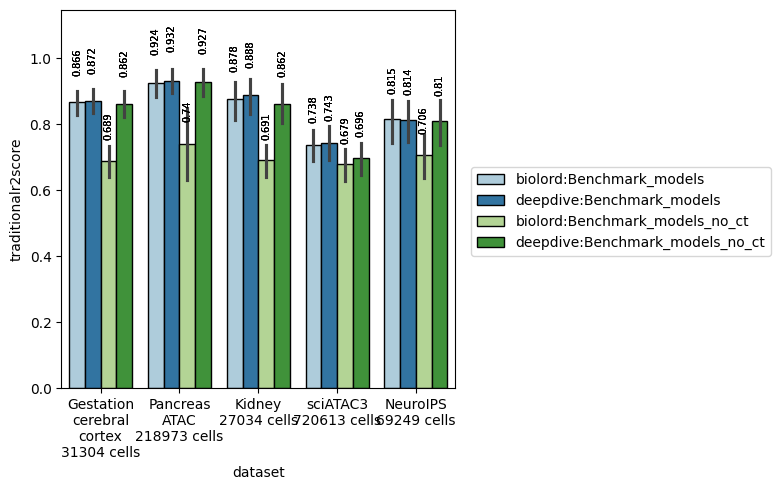

In [137]:
fig, ax = plt.subplots(len(metrics), 1, figsize = (8,5))
for idx, i in enumerate(metrics):
    df_sub = df[df.metric == i]
    kwargs = {'alpha':1, 
              'linewidth':1, 
              'edgecolor':'k'}
    sns.barplot(df_sub, 
                x = 'dataset', 
                y = 'score', 
                hue = 'hue', 
                hue_order = hue_order,
                palette = 'Paired', 
                order = df.sort_values(['n_cells']).dataset.unique().tolist(),
                estimator = 'mean',
                ax = ax,
                legend = True, # if idx == len(metrics) -1 else False,
                **kwargs)

    sns.stripplot(
        df_sub,
        x="dataset", 
        y="score", 
        hue="hue", 
        hue_order = hue_order,
        palette = ['k']*len(hue_order), 
        order = df.sort_values(['n_cells']).dataset.unique().tolist(),
        dodge=True, alpha=0.0,size = 3, ax = ax,
        legend = False
    )

    ax.set_ylabel(i)
    ax.set_ylim([0,max(df_sub.score)*1.15])

    ax.legend(loc=(1.04, 0.35))

    for bars in ax.containers:
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            if isinstance(height, float):
                ax.annotate(f'{float(height):.3}', 
                             (x + width/2, y + height*1.1), 
                             ha='center', rotation=90, fontsize = 7, fontweight = 'light')

plt.tight_layout()
plt.savefig('../figures/S3B.pdf', transparent = True)

## Biolord w celltypes

In [ ]:
adata = sc.read_h5ad("Pancreas_ATAC.h5ad")

In [ ]:
discrete_covriate_keys = ['donor', 'cell_type', 
                          'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', ' 10x multiome assay']
continuous_covriate_keys = ['Islet index', 'Age', 'BMI', 'HbA1c', 'Purity']

In [ ]:
adata.obs.columns = adata.obs.columns.map(lambda x:x.replace('.', ''))

In [ ]:
discrete_covriate_keys = [x.replace('.', '') for x in discrete_covriate_keys]

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model_path = f'../Benchmark_models/biolord/Pancreas_ATAC.pt'


In [ ]:
model.module.load_state_dict(torch.load(model_path))

In [ ]:
model.is_trained = True
model.is_trained_ = True


In [ ]:
z_basal, z = model.get_latent_representation_adata(adata, batch_size=256, )

In [ ]:
sc.pp.neighbors(z_basal)
sc.tl.umap(z_basal, min_dist = 0.2)

In [ ]:
discrete_covriate_keys = ['donor', 'cell_type', 
                          'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', ' 10x multiome assay']

sc.set_figure_params(vector_friendly=True, dpi_save=300, transparent=True) 
sc.pl.umap(z_basal, color = discrete_covriate_keys, size = 1, save = 'S2C2.pdf')



## Biolord wo celltype

In [ ]:
discrete_covriate_keys = ['donor', 
                          'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', ' 10x multiome assay']
continuous_covriate_keys = ['Islet index', 'Age', 'BMI', 'HbA1c', 'Purity']

In [ ]:
adata.obs.columns = adata.obs.columns.map(lambda x:x.replace('.', ''))

In [ ]:
discrete_covriate_keys = [x.replace('.', '') for x in discrete_covriate_keys]

In [ ]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=continuous_covriate_keys,
    categorical_attributes_keys=discrete_covriate_keys,
)

model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params_bl,
    split_key="split",
)

In [ ]:
model_path = f'../Benchmark_models_no_ct/biolord/Pancreas_ATAC.pt'


In [ ]:
model.module.load_state_dict(torch.load(model_path))

In [ ]:
model.is_trained = True
model.is_trained_ = True


In [ ]:
z_basal, z = model.get_latent_representation_adata(adata, batch_size=256, )

In [ ]:
sc.pp.neighbors(z_basal)
sc.tl.umap(z_basal, min_dist = 0.2)

In [ ]:
discrete_covriate_keys = ['donor', 'cell_type', 
                          'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', ' 10x multiome assay']

sc.set_figure_params(vector_friendly=True, dpi_save=300, transparent=True) 
sc.pl.umap(z_basal, color = discrete_covriate_keys, size = 1, save = 'S2C1.pdf')



## DeepDive w celltypes

In [ ]:
discrete_covriate_keys = ['donor', 'cell_type', 
                          'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', ' 10x multiome assay']
continuous_covriate_keys = ['Islet index', 'Age', 'BMI', 'HbA1c', 'Purity']

In [ ]:
adata.obs.columns = adata.obs.columns.map(lambda x:x.replace('.', ''))

In [ ]:
discrete_covriate_keys = [x.replace('.', '') for x in discrete_covriate_keys]

In [ ]:

model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                  
                       )

In [ ]:
model_path = f'../Benchmark_models/deepdive/Pancreas_ATAC.pt'


In [ ]:
model.load_state_dict(torch.load(model_path))

In [ ]:
set_dropout(model)

In [ ]:
z = model.get_latent(
        adata,
        covars_to_add=[],
        batch_size=256,
        num_workers=10,
        add_unknown = True,
        use_decoder = 'all',
    )

In [ ]:
sc.pp.neighbors(z)
sc.tl.umap(z, min_dist = 0.2)

In [ ]:
discrete_covriate_keys = ['donor', 'cell_type', 
                          'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', ' 10x multiome assay']

sc.set_figure_params(vector_friendly=True, dpi_save=300, transparent=True) 
sc.pl.umap(z, color = discrete_covriate_keys, size = 1, save = 'S2C4.pdf')



## DeepDive wo celltypes

In [ ]:
discrete_covriate_keys = ['donor', 
                          'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', ' 10x multiome assay']
continuous_covriate_keys = ['Islet index', 'Age', 'BMI', 'HbA1c', 'Purity']

In [ ]:
adata.obs.columns = adata.obs.columns.map(lambda x:x.replace('.', ''))

In [ ]:
discrete_covriate_keys = [x.replace('.', '') for x in discrete_covriate_keys]

In [ ]:

model = DeepDive.DeepDive(adata = adata, 

                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                          #n_decoders = 5,

                        **model_params
                  
                       )

In [ ]:
model_path = f'../../Benchmark_models_no_ct/deepdive/Pancreas_ATAC.pt'


In [ ]:
model.load_state_dict(torch.load(model_path))

In [ ]:
set_dropout(model)

In [ ]:
z = model.get_latent(
        adata,
        covars_to_add=[],
        batch_size=256,
        num_workers=10,
        add_unknown = True,
        use_decoder = 'all',
    )

In [ ]:
sc.pp.neighbors(z)
sc.tl.umap(z, min_dist = 0.2)

In [ ]:
discrete_covriate_keys = ['donor', 'cell_type', 
                          'Diabetes status', 'Human islet resource center', 'Sex', 'Ethnicity', ' 10x multiome assay']

sc.set_figure_params(vector_friendly=True, dpi_save=300, transparent=True) 
sc.pl.umap(z, color = discrete_covriate_keys, size = 1, save = 'S2C4.pdf')

